In [177]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from fastai.vision import *
from fastai import *

In [206]:
test_df = pd.read_csv('LC_TestData.csv',low_memory=False)
train_df = pd.read_csv('LC_TrainingData.csv',low_memory=False)
dataset = [test_df, train_df]
print(train_df.shape,test_df.shape)

(103546, 21) (96779, 22)


# Data preprocessing

### 1. Target variable

"Loan status" tells if the payments of a loan are in time. 
- ("grace period", "late", "charged off", "default") => the loan is in default
- ("current", "fully paid") => not in default

__Severely inbalanced target variable__: may cause problems, depending on models. Possible solutions: upsampling 

In [179]:
# create target variable 
train_df['target'] = 1 # default
train_df.loc[(train_df['loan_status']=='Current') |            # not default
             (train_df['loan_status']=='Fully Paid'),'target'] = 0  
train_df = train_df.drop('loan_status',axis=1)

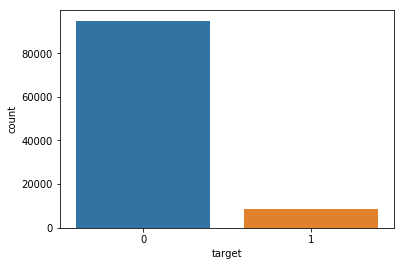

In [180]:
sns.countplot(train_df['target']);

### 2. Missing values
1. 'desc' column is 100% NA , simply remove it. 
2. 'mths_since_last_delinq' NA can be interpreted as last default case is very long time ago, therefore we should fill NA with a very large value. 
3. 'mths_since_last_record' NA can be interpreted as new users with no previous record, therefore fill NA with 0.
4. emp_title, emp_length NA can be treated as unemployed, or not provided. Either way, we could fill emp_title as empty string '', emp_length as 0.
5. dti is the ratio of total debt obligations(excluding mortgage and the requested Lending Club loan)/income, it represents the percentage of income that goes to debt payment. dit NA can be permuted with the average/mode dti. Because it's safer and more probable to assume that an applicant's dti is the average/most common dti, than any other extreme values such as 0 or 1. Also there are only 28 missing values, so the mean fills have negalectable impact on the dataset. 
6. there are only 4 title NAs, it's safe to fill those NAs with the most common title value. 

In [181]:
# show missing values
NAs = pd.concat([np.sum(train_df.isna()), 
                 (100*np.sum(train_df.isna())/train_df.shape[0]).map('{:,.0f}'.format)],
                axis=1, keys = ['NA count','NA percentage'])
NAs.loc[NAs['NA count']>0].sort_values('NA count',ascending=False)

,NA count,NA percentage
desc,103545,100
mths_since_last_record,82466,80
mths_since_last_delinq,47774,46
emp_title,7048,7
emp_length,6877,7
dti,28,0
title,4,0


In [182]:
# Drop and fill NAs
train_df = train_df.drop('desc',axis=1)
train_df['mths_since_last_record'].fillna(0, inplace=True)
train_df['mths_since_last_delinq'].fillna(1000, inplace=True)
train_df['emp_title'].fillna('', inplace=True)
train_df['emp_length'].fillna(0, inplace=True)
train_df['dti'].fillna(train_df['dti'].mean(), inplace=True)
train_df['title'].fillna(train_df['title'].mode().item(), inplace=True)

### 3. Numerical variables
1. Extremely long tail left-skewed distributions: annual_inc, dti, delinq_2yrs, open_acc, pub_rec, may need to normalize them or log-scale transform. 
2. 'loan_amnt' and 'installment' are highly correlated, produce their interaction terms might be helpful to capture their correlation. 

In [183]:
num_columns = train_df.select_dtypes(include=['number']).columns
print(f'A total of {num_columns.size} numerical variables: ')
print(list(num_columns))

A total of 11 numerical variables: 
['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'target']


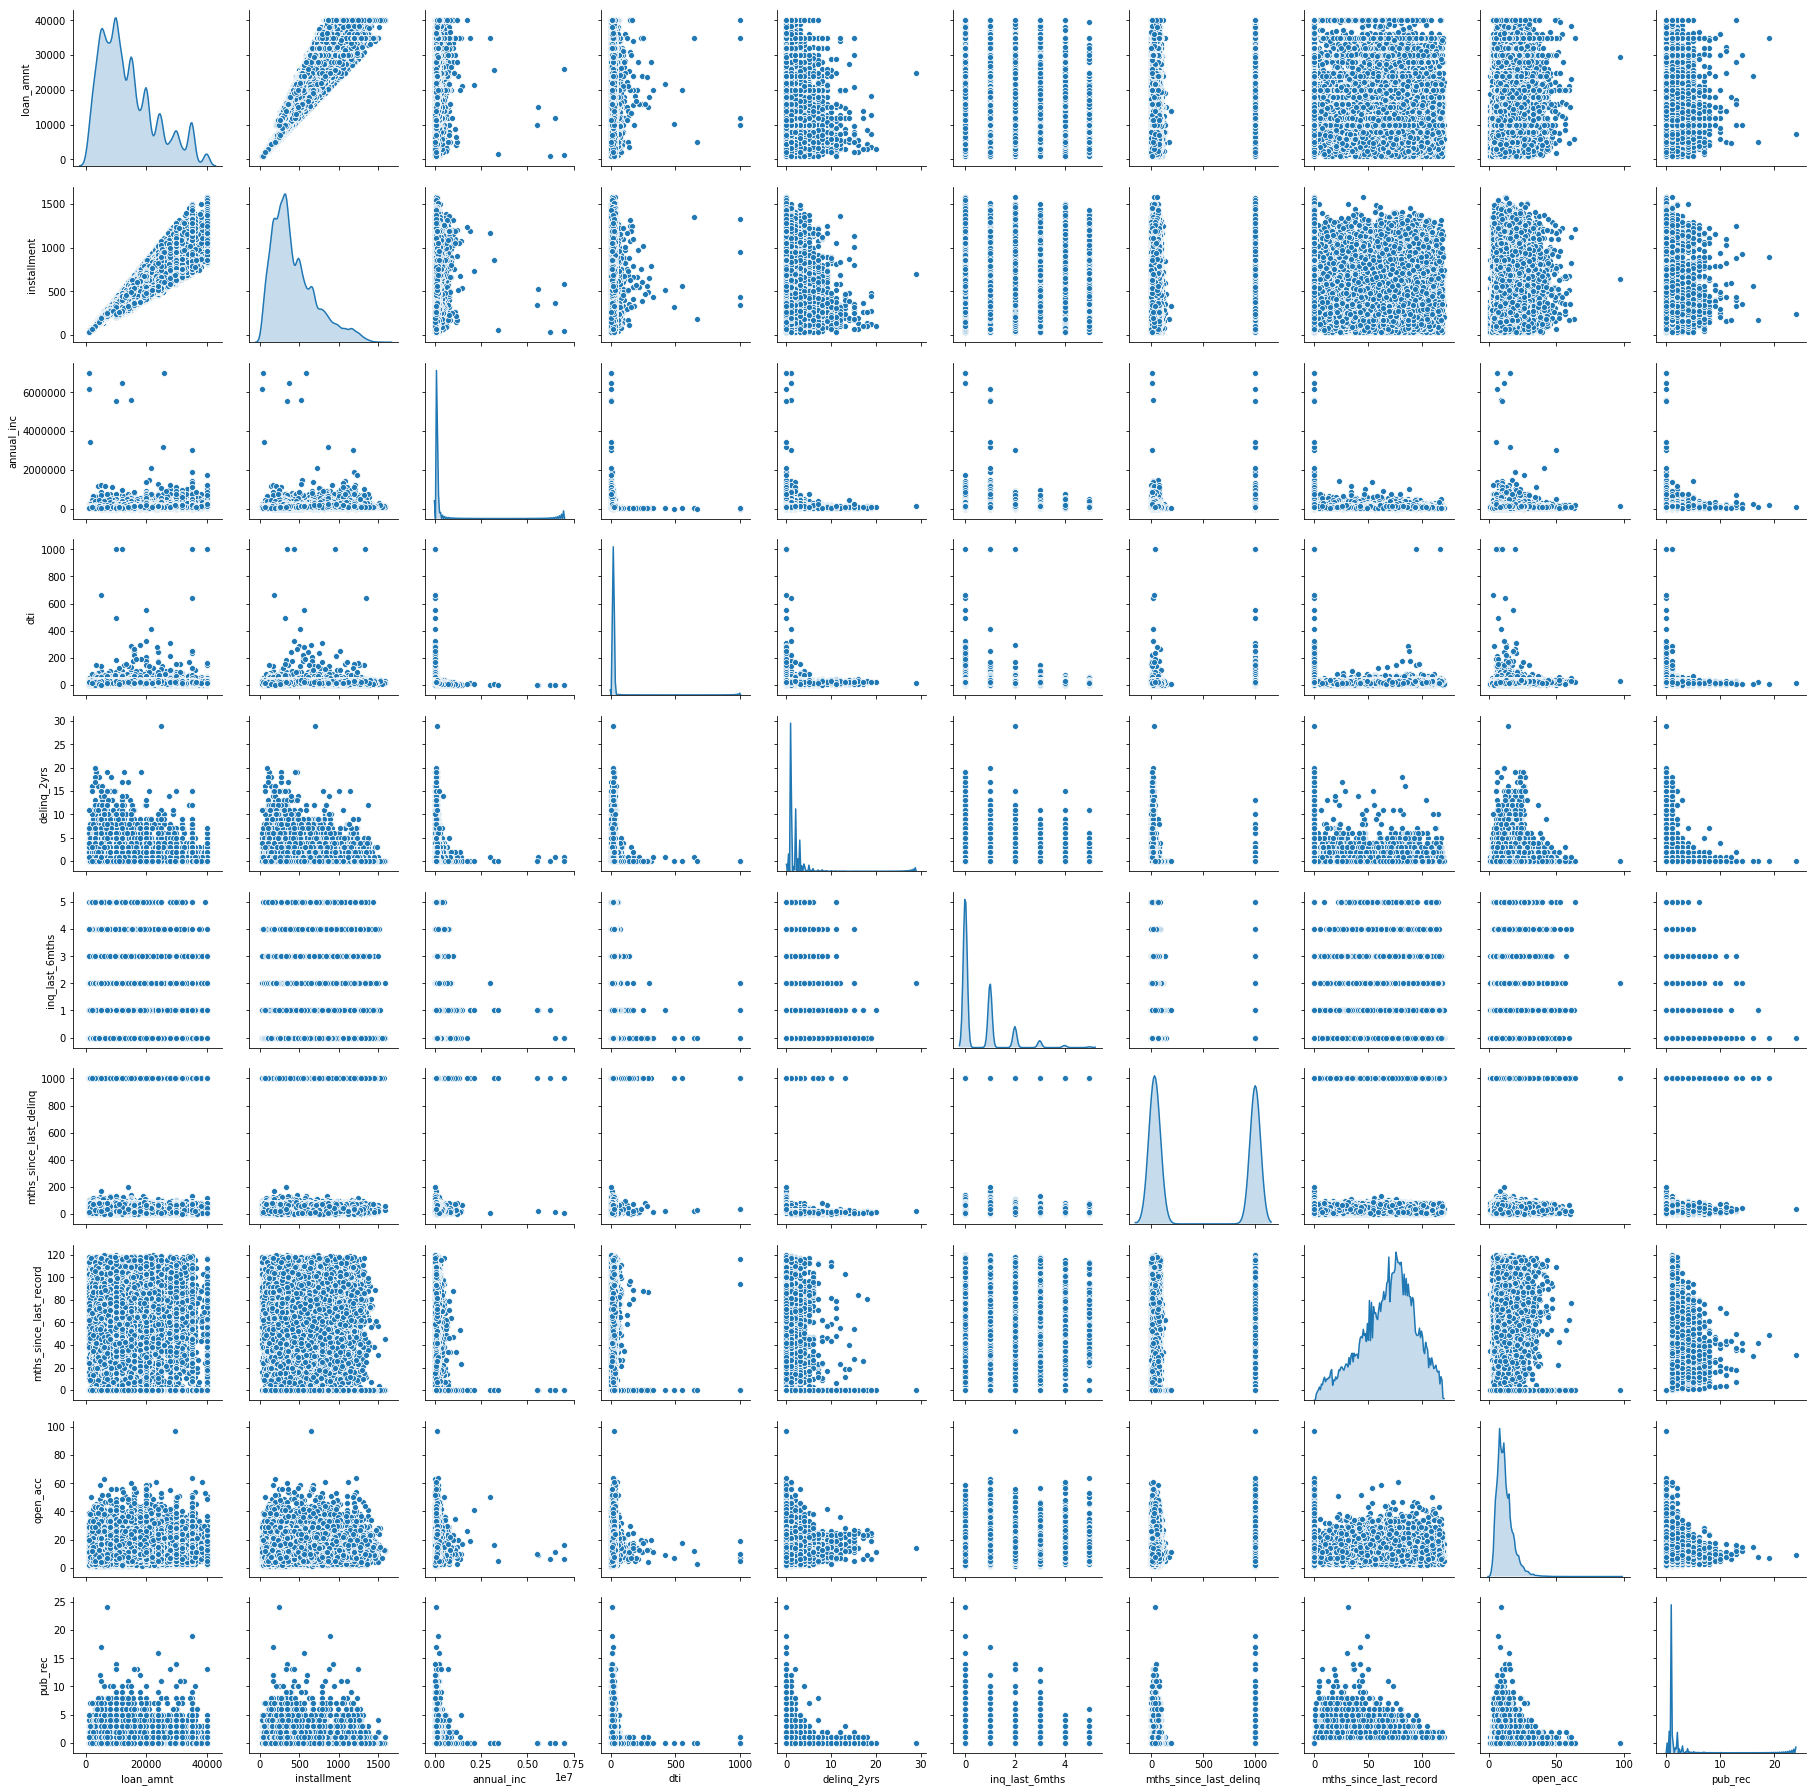

In [162]:
# plot Numerical variable distributions and correlations
sns.pairplot(train_df[num_columns],diag_kind='kde');

In [184]:
# Log-scale transform / normalization of numerical values
# done later with sklearn in numpy array

### 4. Categorical variables
1. __emp_title__ has huge amount of possible categories. 
    - Try __one-hot-encoding 'emp_title' vs removing it__    
        - If we do one-hot-encoding with all 38367 unique categories, then the feature space becomes very large and spase. 
        - It may be fine with regularization, but it still increases risks of overfitting. 
    - Create a __new feature: 'management_role'__, which = 1 if loander is in a senior or management position, 0 otherwise.
2. __zip_code__ also has large category space, it's correlated to addr_state, but gives finer geographical proximity information eg. 723xx is close to 724xx. 
    - NO: use numerical value => compare closeness  
    - YES: __one-hot-encoding__ => ignore proximity, only check if particular zip_code is useful for prediction or not. 
        - problem: new zip_code that are not in traning data will not be used because model hasn't learn the parameters for it 
3. !!! __Remove 'earliest_cr_line'__ for now, due to ambiguity 
    - problem: April.00 ==> 1900 or 2000?
4. __'addr_state', 'title', 'home_ownership', 'verification_status', 'term'__ doesn't have order, use __one-hot-encoding__ to convert to numerical values
5. __'emp_length'__ has order and should be changed into __ordinal categorical variable__

In [185]:
# list of columns that are not numerical 
str_columns = train_df.select_dtypes(include=['object']).columns
print(f'A total of {str_columns.size} str categorical variables: ')
# unique category count
unique_value_count = [len(train_df[col].unique()) for col in str_columns]
unique_value_rank = pd.DataFrame(unique_value_count,index = str_columns,
             columns=['Unique value count']).sort_values('Unique value count',ascending=False)
display(unique_value_rank)
display(train_df[unique_value_rank.index].head())

A total of 9 str categorical variables: 


,Unique value count
emp_title,38367
zip_code,868
earliest_cr_line,621
addr_state,49
emp_length,12
title,12
home_ownership,4
verification_status,3
term,2


,emp_title,zip_code,earliest_cr_line,addr_state,emp_length,title,home_ownership,verification_status,term
0,Senior Director,070xx,Oct.99,NJ,9 years,Home improvement,MORTGAGE,Not Verified,60 months
1,Lead machine operator,531xx,Apr.11,WI,6 years,Credit card refinancing,RENT,Not Verified,36 months
2,IT Specialist 6,984xx,Aug.94,WA,10+ years,Credit card refinancing,RENT,Not Verified,36 months
3,Nurse,112xx,Feb.92,NY,2 years,Debt consolidation,RENT,Not Verified,36 months
4,Lead ultrasound technologist,453xx,May.00,OH,10+ years,Debt consolidation,MORTGAGE,Source Verified,36 months


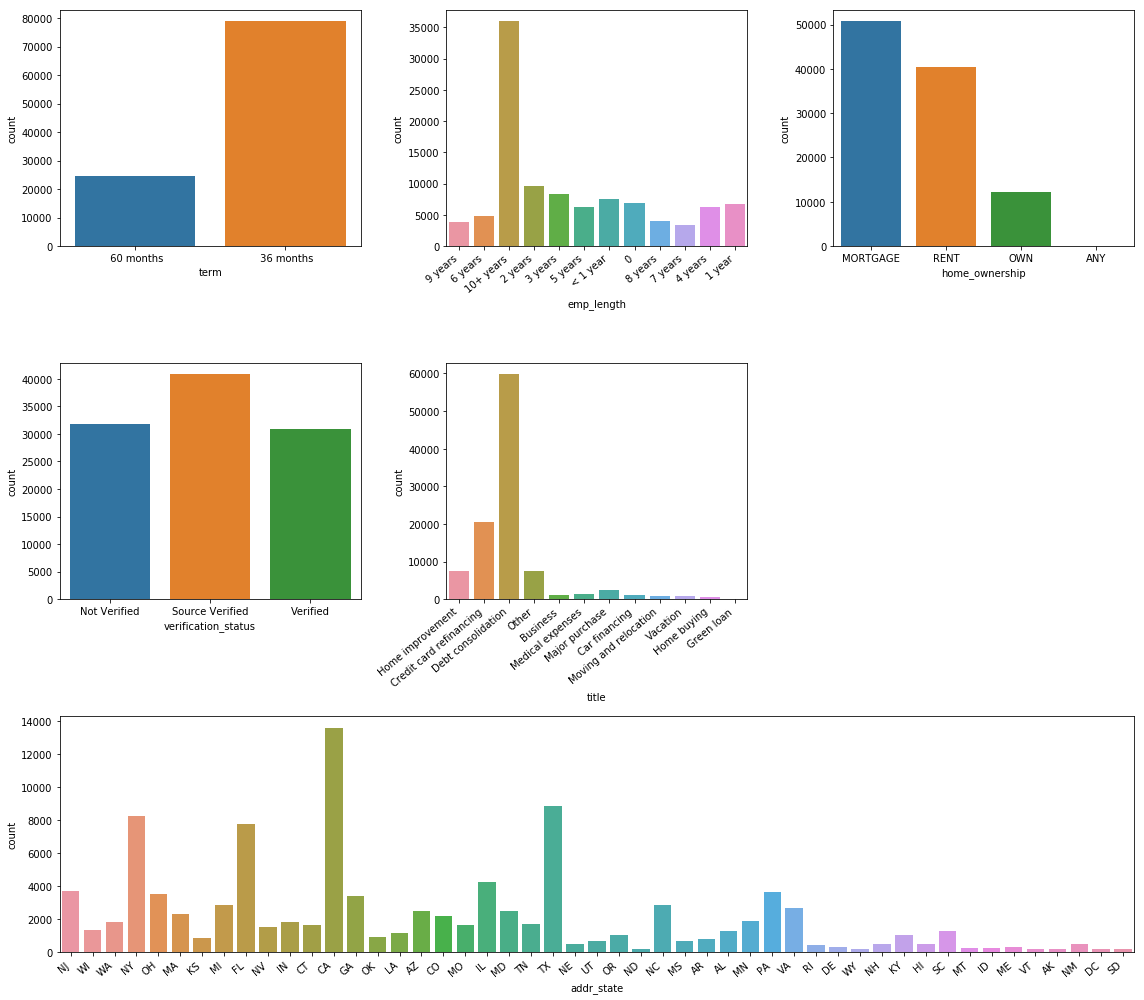

In [186]:
# plot categorical variable distributions

# list of categorical variables with number of categories<=20
cats = [c for c in str_columns if len(train_df[c].unique())<=20]

fig = plt.figure(figsize=(16,14))
for i in range(len(cats)+1):
    
    # make grids
    if i < len(cats):
        ax = fig.add_subplot(331+i)
        variable = train_df[cats[i]]
    else:
        ax = fig.add_subplot(313)
        variable = train_df['addr_state']
    
    s = sns.countplot(variable,ax=ax) 
    if len(variable.unique()) > 4:
        s.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

#### emp_title

In [187]:
# new features: whether the loaner is in a senior or management position
senior_positions = 'manager|supervisor|superviser|owner|president \
                    |senior|director|leader'
# boolean map that check if is senior/manager
is_senior = train_df['emp_title'].str.lower().str.contains(senior_positions)
print('%.2f%%'% (100*train_df[is_senior].shape[0]/train_df.shape[0]),'loaners are in senior or management positions.')
# create new feature
train_df['management_role'] = 0
train_df.loc[is_senior, 'management_role'] = 1
# Test: remove emp_title vs onehotencode
train_df = train_df.drop('emp_title',axis=1)

27.17% loaners are in senior or management positions.


#### earliest_cr_line

In [188]:
### !!! Not to use 'earliest_cr_line' for now, due to ambiguity !!! ###
### !!! problem: April.00 ==> 1900 or 2000??? ###
def month_diff(date):
    # convert str to datetime 
    then=datetime.strptime(date, '%b.%y')
    now = datetime(2019, 4, 1, 0, 0, 0, 0)
    # time difference between fisrt credit line and now
    diff = now-then 
    # return number of months
    return diff.days/30
train_df = train_df.drop('earliest_cr_line',axis=1)
#train_df['mths_since_1st_credit_line']=train_df['earliest_cr_line'].map(month_diff)
#train_df = train_df.drop('mths_since_1st_credit_line',axis=1)

#### zip code

In [189]:
# Option 1: one-hot-encoding 
# Option 2: remove 'xx', convert to numerical value
# Option 3: remove it 

# option 1
onehot = pd.get_dummies(train_df['zip_code'])
train_df = train_df.join(onehot)
train_df.drop('zip_code', axis=1, inplace=True)

#### one hot encoding

In [190]:
cols_for_onehot = ['addr_state', 'title', 'home_ownership', 
                   'verification_status','term']
onehot = pd.get_dummies(train_df[cols_for_onehot])
train_df = train_df.join(onehot)
train_df.drop(cols_for_onehot, axis=1, inplace=True)

#### emp_length

In [191]:
order=[0,'< 1 year','1 years','2 years','3 years','4 years','5 years',
       '6 years','7 years','8 years','9 years','10+ years']
train_df['emp_length'] = pd.Categorical(train_df['emp_length'],
                                        ordered=True,
                                        categories = order)
train_df['emp_length'] = train_df['emp_length'].cat.codes
#train_df.drop('emp_length', axis=1, inplace=True)

## Final check and Export to csv

In [192]:
print(train_df.shape)
train_df.head()

(103546, 951)


,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,title_Vacation,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,term_ 36 months,term_ 60 months
0,14400,291.92,10,135000.0,6.60,1,0,11.0,0.0,15,...,0,0,1,0,0,1,0,0,0,1
1,4500,151.06,7,32000.0,29.93,0,1,1000.0,0.0,7,...,0,0,0,0,1,1,0,0,1,0
2,3600,118.53,11,89712.0,20.30,0,0,1000.0,0.0,16,...,0,0,0,0,1,1,0,0,1,0
3,7000,210.81,3,85000.0,12.80,1,0,20.0,30.0,14,...,0,0,0,0,1,1,0,0,1,0
4,39000,1370.94,11,78000.0,33.14,0,0,1000.0,0.0,17,...,0,0,1,0,0,0,1,0,1,0


In [193]:
# export to csv
train_df.to_csv('processed_train.csv')

# Test set
????
- do we have to use test set for testing? train set for training and validation? or can we combine both?? 
- interest rate is only in test set, so if we only use train set for training, then it's useless since our model doesn't know anything about it

In [207]:
# create target variable 
test_df['target'] = 1 # default
test_df.loc[(test_df['loan_status']=='Current') |            # not default
             (test_df['loan_status']=='Fully Paid'),'target'] = 0  
test_df = test_df.drop('loan_status',axis=1)

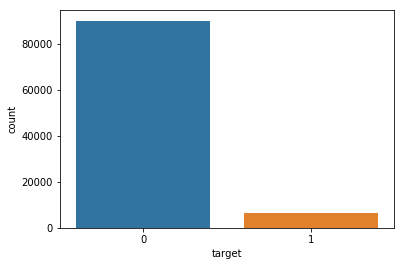

In [208]:
sns.countplot(test_df['target']);

#### 2. Missing values
same as train

In [209]:
# show missing values
NAs = pd.concat([np.sum(test_df.isna()), 
                 (100*np.sum(test_df.isna())/test_df.shape[0]).map('{:,.0f}'.format)],
                axis=1, keys = ['NA count','NA percentage'])
NAs.loc[NAs['NA count']>0].sort_values('NA count',ascending=False)

,NA count,NA percentage
desc,96779,100
mths_since_last_record,77674,80
mths_since_last_delinq,46293,48
emp_title,6892,7
emp_length,6792,7
dti,33,0
zip_code,1,0


In [210]:
# Drop and fill NAs
test_df = test_df.drop('desc',axis=1)
test_df['mths_since_last_record'].fillna(0, inplace=True)
test_df['mths_since_last_delinq'].fillna(1000, inplace=True)
test_df['emp_title'].fillna('', inplace=True)
test_df['emp_length'].fillna(0, inplace=True)
test_df['dti'].fillna(test_df['dti'].mean(), inplace=True)
test_df['title'].fillna(test_df['title'].mode().item(), inplace=True)
test_df['zip_code'].fillna(test_df['zip_code'].mode().item(), inplace=True)

#### 3. Numerical variables
same as train
- convert interest rate to numerical value

In [211]:
num_columns = test_df.select_dtypes(include=['number']).columns
print(f'A total of {num_columns.size} numerical variables: ')
print(list(num_columns))

A total of 11 numerical variables: 
['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'target']


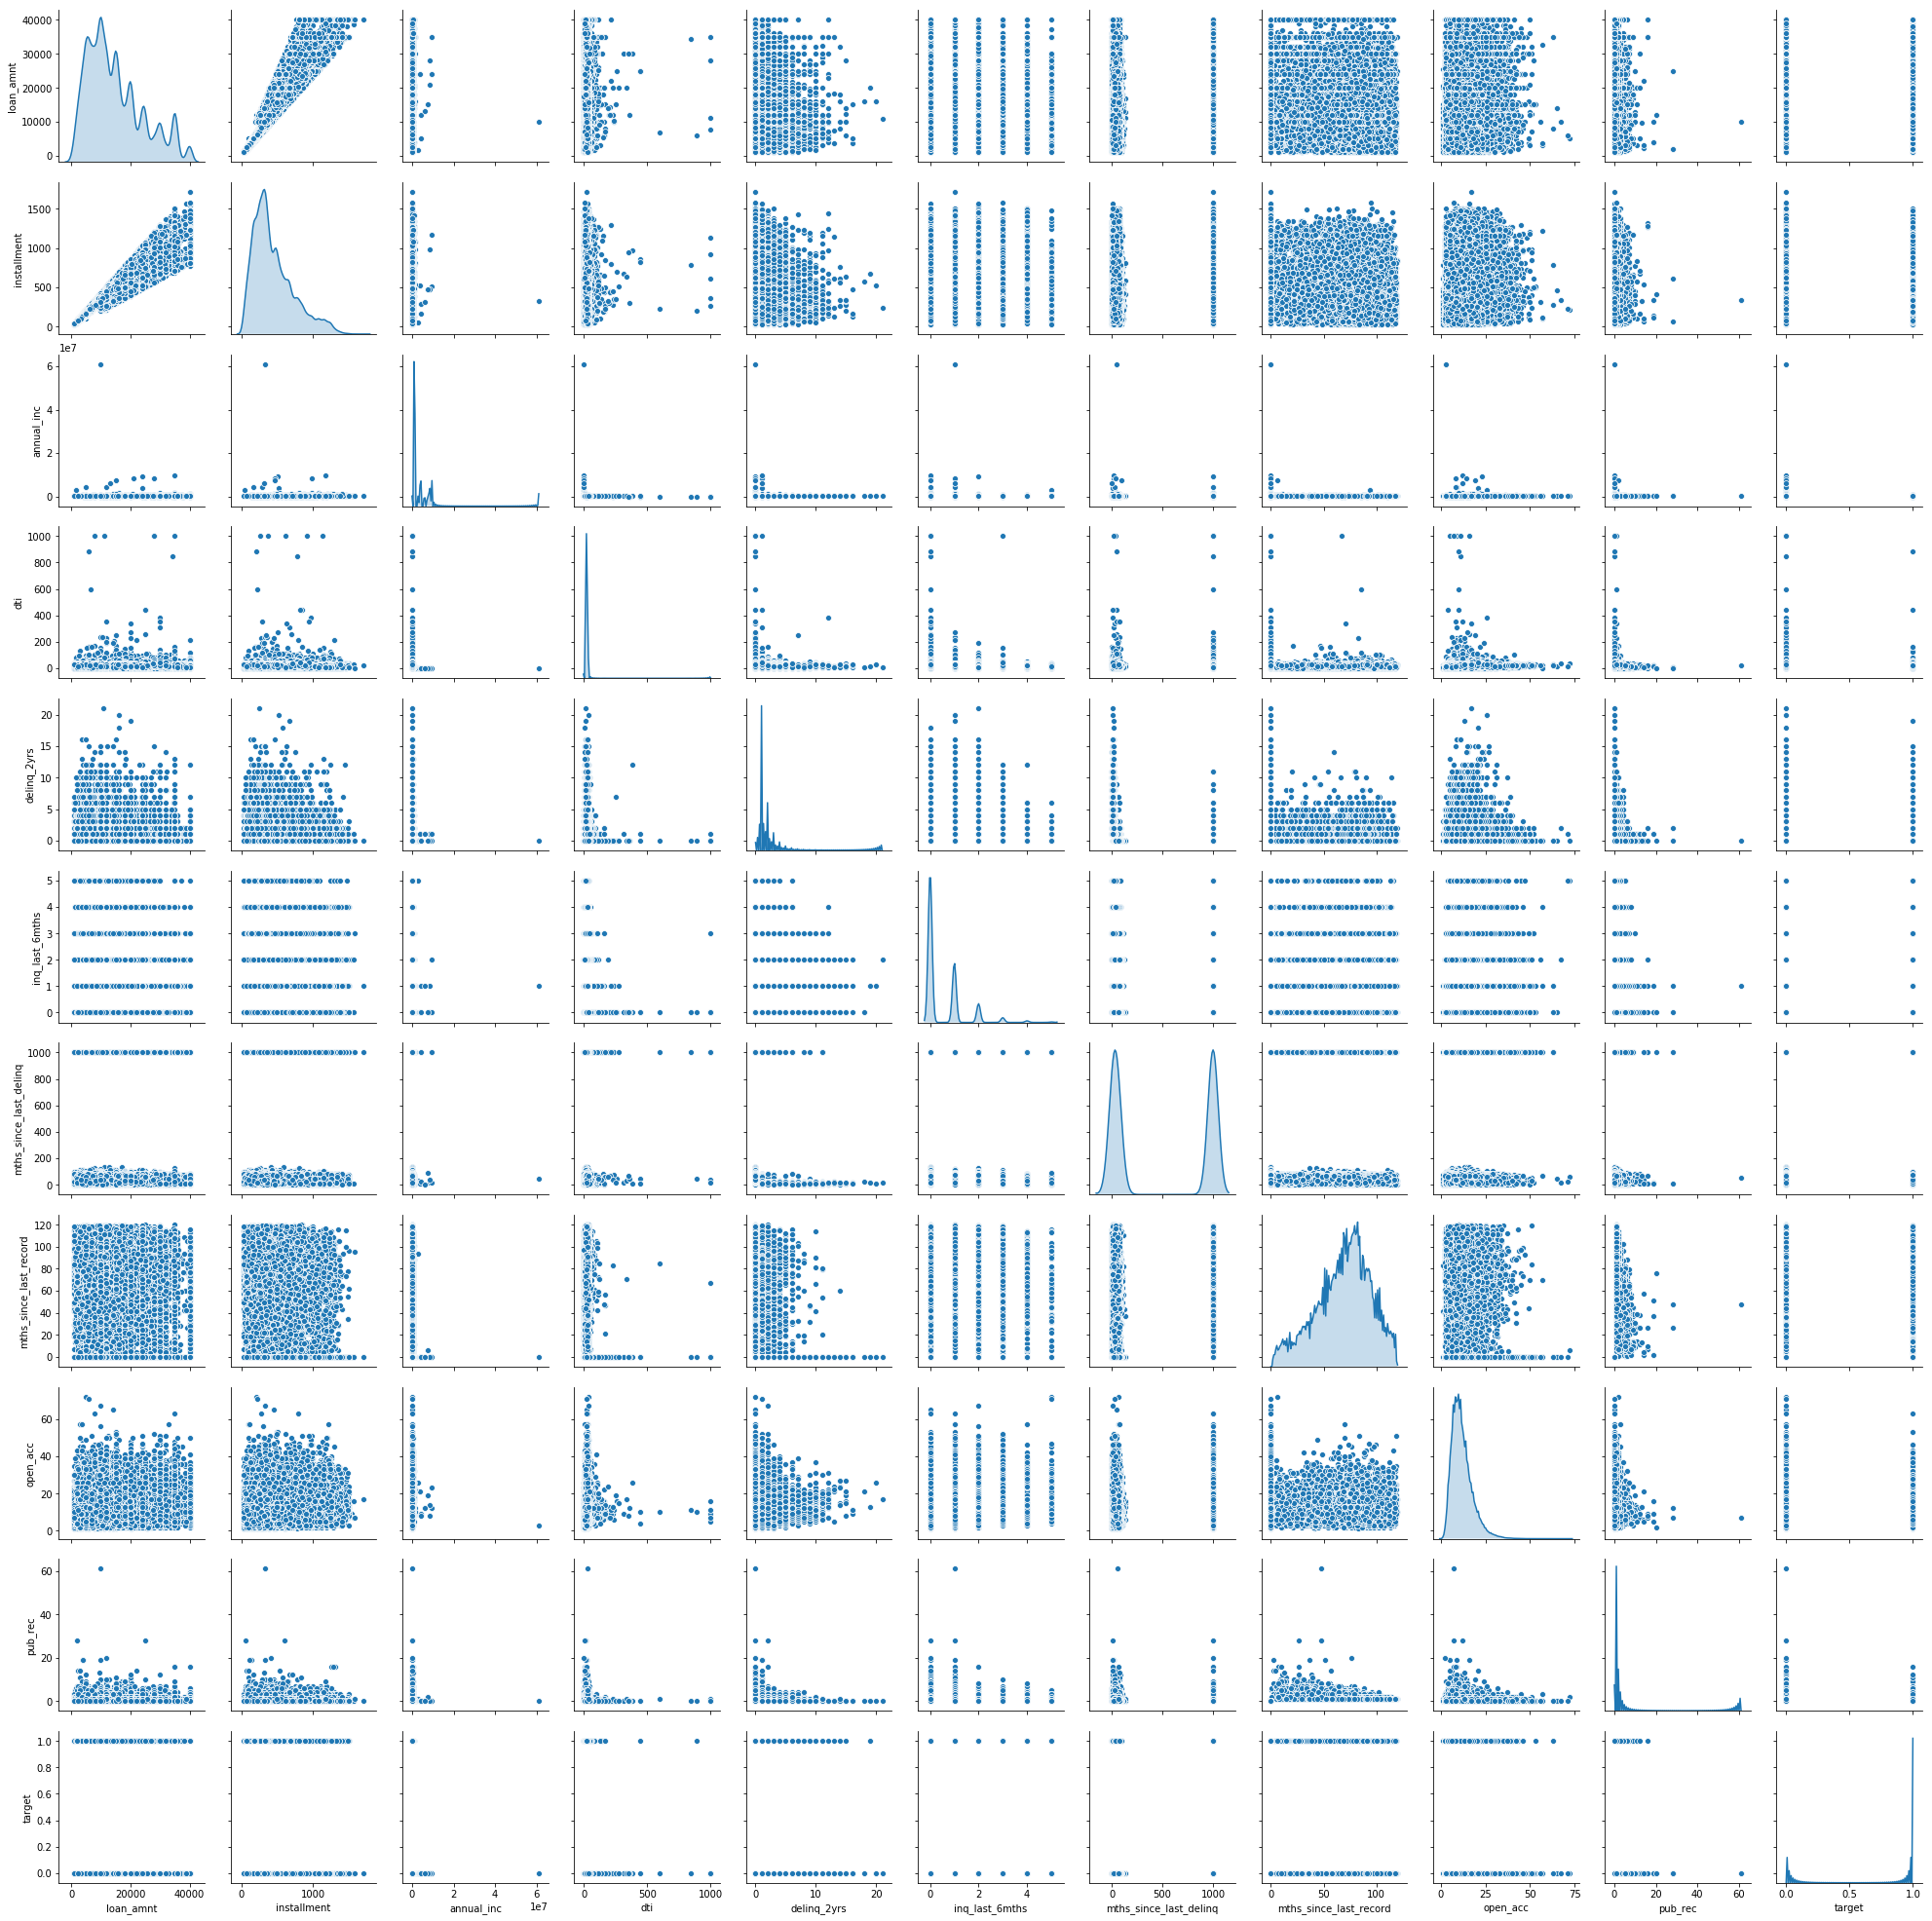

In [213]:
# plot Numerical variable distributions and correlations
sns.pairplot(test_df[num_columns],diag_kind='kde');

In [214]:
# Log-scale transform / normalization of numerical values
# done later with sklearn in numpy array

#### 4. Categorical variables
1. __emp_title__ has huge amount of possible categories. 
    - Try __one-hot-encoding 'emp_title' vs removing it__    
        - If we do one-hot-encoding with all 38367 unique categories, then the feature space becomes very large and spase. 
        - It may be fine with regularization, but it still increases risks of overfitting. 
    - Create a __new feature: 'management_role'__, which = 1 if loander is in a senior or management position, 0 otherwise.
2. __zip_code__ also has large category space, it's correlated to addr_state, but gives finer geographical proximity information eg. 723xx is close to 724xx. 
    - NO: use numerical value => compare closeness  
    - YES: __one-hot-encoding__ => ignore proximity, only check if particular zip_code is useful for prediction or not. 
        - problem: new zip_code that are not in traning data will not be used because model hasn't learn the parameters for it 
3. !!! __Remove 'earliest_cr_line'__ for now, due to ambiguity 
    - problem: April.00 ==> 1900 or 2000?
4. __'addr_state', 'title', 'home_ownership', 'verification_status', 'term'__ doesn't have order, use __one-hot-encoding__ to convert to numerical values
5. __'emp_length'__ has order and should be changed into __ordinal categorical variable__

In [215]:
# list of columns that are not numerical 
str_columns = test_df.select_dtypes(include=['object']).columns
print(f'A total of {str_columns.size} str categorical variables: ')
# unique category count
unique_value_count = [len(test_df[col].unique()) for col in str_columns]
unique_value_rank = pd.DataFrame(unique_value_count,index = str_columns,
             columns=['Unique value count']).sort_values('Unique value count',ascending=False)
display(unique_value_rank)
display(test_df[unique_value_rank.index].head())

A total of 10 str categorical variables: 


,Unique value count
emp_title,35501
zip_code,862
earliest_cr_line,620
addr_state,49
int_rate,36
emp_length,12
title,12
home_ownership,5
verification_status,3
term,2


,emp_title,zip_code,earliest_cr_line,addr_state,int_rate,emp_length,title,home_ownership,verification_status,term
0,Executive Account Manager,751xx,Nov.74,TX,5.32%,10+ years,Debt consolidation,MORTGAGE,Not Verified,36 months
1,Air Traffic Controller,840xx,Oct.05,UT,7.49%,10+ years,Debt consolidation,MORTGAGE,Not Verified,36 months
2,Associate Dentist,926xx,Aug.02,CA,5.32%,3 years,Credit card refinancing,RENT,Not Verified,36 months
3,claims analyst,577xx,Jul.95,SD,12.74%,10+ years,Debt consolidation,MORTGAGE,Not Verified,60 months
4,Supervisor,983xx,Oct.07,WA,16.99%,6 years,Credit card refinancing,MORTGAGE,Not Verified,36 months


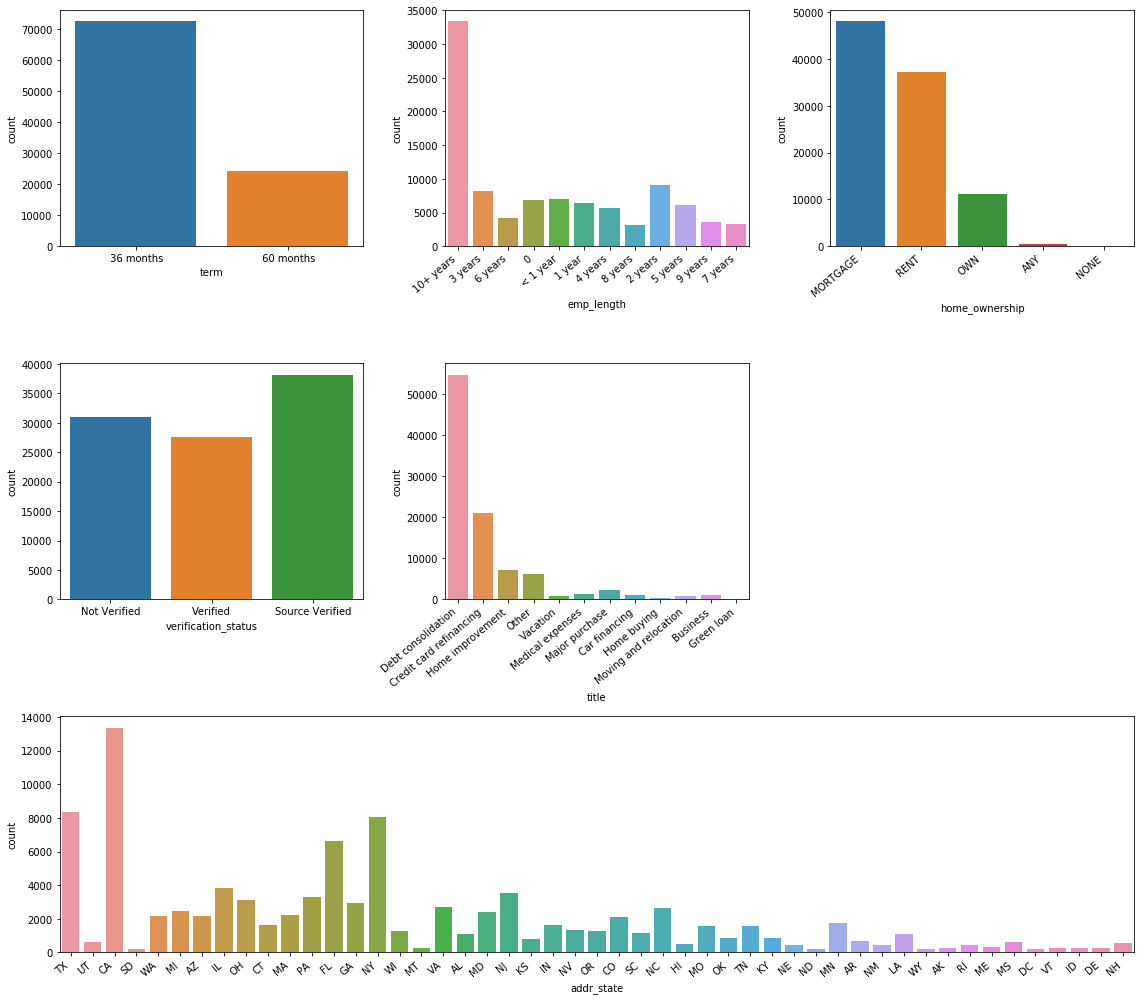

In [216]:
# plot categorical variable distributions

# list of categorical variables with number of categories<=20
cats = [c for c in str_columns if len(test_df[c].unique())<=20]

fig = plt.figure(figsize=(16,14))
for i in range(len(cats)+1):
    
    # make grids
    if i < len(cats):
        ax = fig.add_subplot(331+i)
        variable = test_df[cats[i]]
    else:
        ax = fig.add_subplot(313)
        variable = test_df['addr_state']
    
    s = sns.countplot(variable,ax=ax) 
    if len(variable.unique()) > 4:
        s.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

#### emp_title

In [217]:
# new features: whether the loaner is in a senior or management position
senior_positions = 'manager|supervisor|superviser|owner|president \
                    |senior|director|leader'
# boolean map that check if is senior/manager
is_senior = test_df['emp_title'].str.lower().str.contains(senior_positions)
print('%.2f%%'% (100*test_df[is_senior].shape[0]/test_df.shape[0]),'loaners are in senior or management positions.')
# create new feature
test_df['management_role'] = 0
test_df.loc[is_senior, 'management_role'] = 1
# Test: remove emp_title vs onehotencode
test_df = test_df.drop('emp_title',axis=1)

27.28% loaners are in senior or management positions.


#### earliest_cr_line

In [218]:
### !!! Not to use 'earliest_cr_line' for now, due to ambiguity !!! ###
### !!! problem: April.00 ==> 1900 or 2000??? ###
def month_diff(date):
    # convert str to datetime 
    then=datetime.strptime(date, '%b.%y')
    now = datetime(2019, 4, 1, 0, 0, 0, 0)
    # time difference between fisrt credit line and now
    diff = now-then 
    # return number of months
    return diff.days/30
test_df = test_df.drop('earliest_cr_line',axis=1)
#test_df['mths_since_1st_credit_line']=test_df['earliest_cr_line'].map(month_diff)
#test_df = test_df.drop('mths_since_1st_credit_line',axis=1)

#### zip code

In [219]:
# Option 1: one-hot-encoding 
# Option 2: remove 'xx', convert to numerical value
# Option 3: remove it 

# option 1
onehot = pd.get_dummies(test_df['zip_code'])
test_df = test_df.join(onehot)
test_df.drop('zip_code', axis=1, inplace=True)

#### one hot encoding

In [220]:
cols_for_onehot = ['addr_state', 'title', 'home_ownership', 
                   'verification_status','term']
onehot = pd.get_dummies(test_df[cols_for_onehot])
test_df = test_df.join(onehot)
test_df.drop(cols_for_onehot, axis=1, inplace=True)

#### emp_length

In [221]:
order=[0,'< 1 year','1 years','2 years','3 years','4 years','5 years',
       '6 years','7 years','8 years','9 years','10+ years']
test_df['emp_length'] = pd.Categorical(test_df['emp_length'],
                                        ordered=True,
                                        categories = order)
test_df['emp_length'] = test_df['emp_length'].cat.codes
#test_df.drop('emp_length', axis=1, inplace=True)

## Final check and Export to csv

In [222]:
print(test_df.shape)
test_df.head()

(96779, 947)


,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,term_ 36 months,term_ 60 months
0,15000,5.32%,451.73,11,182000.0,9.35,0,0,1000.0,0.0,...,0,1,0,0,0,1,0,0,1,0
1,17000,7.49%,528.73,11,120000.0,8.41,0,0,72.0,89.0,...,0,1,0,0,0,1,0,0,1,0
2,20000,5.32%,602.30,4,120000.0,26.54,0,1,1000.0,0.0,...,0,0,0,0,1,1,0,0,1,0
3,16000,12.74%,361.93,11,130000.0,8.28,0,0,42.0,79.0,...,0,1,0,0,0,1,0,0,0,1
4,2000,16.99%,71.30,7,62000.0,16.43,0,2,57.0,44.0,...,0,1,0,0,0,1,0,0,1,0


In [223]:
# export to csv
test_df.to_csv('processed_test.csv')

### Note that it's not the final version!!!
- Train test set have different number of features due to one-hot-encoded categorical variables have slightly different values. I'll fix this tomorrow!
- There are still things to be tested and decided.